# ĐỒ ÁN: DỊCH MÁY ANH-PHÁP VỚI MÔ HÌNH ENCODER-DECODER LSTM

**Học kỳ:** HK1 / 2025-2026
**Đề tài:** Triển khai mô hình dịch máy Anh-Pháp sử dụng kiến trúc Encoder-Decoder với LSTM và Context Vector cố định.





## I. CÀI ĐẶT THƯ VIỆN VÀ THIẾT LẬP MÔI TRƯỜNG

**Yêu cầu:** Triển khai bằng Python và PyTorch, không sử dụng thư viện seq2seq có sẵn.

In [2]:
# Cell 1: Cài đặt Thư viện và Thiết lập Môi trường

import os
import random
import time
import math
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt # Thêm thư viện vẽ biểu đồ

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import spacy
from nltk.translate.bleu_score import corpus_bleu

# ----------------------------------------------------
# THIẾT LẬP MÔI TRƯỜNG & TẢI SPACY
# ----------------------------------------------------

# Cài đặt các thư viện bắt buộc (Chạy lần đầu)
!pip install torch spacy nltk numpy matplotlib

# Tải các mô hình ngôn ngữ Spacy (Chạy lần đầu)
# Lưu ý: Các file này phải có sẵn hoặc được tải trong bước chuẩn bị.
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

# Tải Spacy model
try:
    spacy_en = spacy.load("en_core_web_sm")
    spacy_fr = spacy.load("fr_core_news_sm")
    print("Spacy models loaded successfully.")
except OSError:
    print("Vui lòng chạy lệnh cài đặt Spacy: !python -m spacy download en_core_web_sm và fr_core_news_sm")
    # exit()

# Khởi tạo thư mục (Giả định người dùng đã tải 6 file dữ liệu vào data/raw)
!mkdir -p data/raw
!mkdir -p checkpoints
print("Đã tạo thư mục data/raw và checkpoints.")

# Device và Seed
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

print(f"Sử dụng thiết bị: {DEVICE}")

# Token đặc biệt và giới hạn Vocab
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
SPECIAL_TOKENS = ['<unk>', '<pad>', '<sos>', '<eos>']
VOCAB_SIZE_LIMIT = 10000

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 81.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 128.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Spacy models loaded successfully.
Đã tạo thư mục data/raw và checkpoints.
Sử dụng thiết bị: cuda


In [3]:
# Cell 2: Các hàm Utility (Tải dữ liệu, Tokenizer, Custom Vocab)

def tokenize_en(text):
    """Tokenize tiếng Anh"""
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
    """Tokenize tiếng Pháp"""
    return [tok.text.lower() for tok in spacy_fr.tokenizer(text)]

def load_data(filepath_en, filepath_fr):
    """Đọc dữ liệu từ file và trả về danh sách các cặp câu (en, fr)"""
    if not os.path.exists(filepath_en) or not os.path.exists(filepath_fr):
        # Trả về list rỗng nếu file không tồn tại
        return []

    with open(filepath_en, encoding='utf-8') as f_en, open(filepath_fr, encoding='utf-8') as f_fr:
        raw_pairs = []
        for en_line, fr_line in zip(f_en, f_fr):
            raw_pairs.append((en_line.strip(), fr_line.strip()))
    return raw_pairs


class CustomVocab:
    """Lớp Vocab tùy chỉnh để thay thế torchtext.vocab"""
    def __init__(self, token_list, specials, default_index):
        self.stoi = {token: i for i, token in enumerate(specials)}
        current_index = len(specials)

        for token in token_list:
            if token not in self.stoi:
                self.stoi[token] = current_index
                current_index += 1

        self.itos = specials + [token for token in token_list if token not in specials]
        self.default_index = default_index

    def get_stoi(self):
        return self.stoi

    def get_itos(self):
        return self.itos

    def __len__(self):
        return len(self.itos)

def get_token_frequency(data_pairs, tokenizer, lang_index):
    """Tính tần suất của tất cả token trong tập dữ liệu."""
    counter = Counter()
    for pair in data_pairs:
        text = pair[lang_index]
        counter.update(tokenizer(text))
    return counter

In [4]:
# Cell 3: Xử lý Dữ liệu và DataLoader (Data Processing & Custom Collate)

# 1. Tải dữ liệu huấn luyện (dùng để xây dựng vocab)
train_pairs = load_data('data/raw/train.en', 'data/raw/train.fr')
if not train_pairs:
    raise FileNotFoundError("Lỗi: Không tìm thấy dữ liệu. Vui lòng tải 6 file vào thư mục data/raw.")

# 2. Xây dựng Vocab (Top 10k từ)
src_counter = get_token_frequency(train_pairs, tokenize_en, 0)
trg_counter = get_token_frequency(train_pairs, tokenize_fr, 1)

src_vocab_list = [item[0] for item in src_counter.most_common(VOCAB_SIZE_LIMIT)]
trg_vocab_list = [item[0] for item in trg_counter.most_common(VOCAB_SIZE_LIMIT)]

vocab_src = CustomVocab(src_vocab_list, SPECIAL_TOKENS, UNK_IDX)
vocab_trg = CustomVocab(trg_vocab_list, SPECIAL_TOKENS, UNK_IDX)

INPUT_DIM = len(vocab_src)
OUTPUT_DIM = len(vocab_trg)
print(f"Kích thước Vocab (Source): {INPUT_DIM}")
print(f"Kích thước Vocab (Target): {OUTPUT_DIM}")


def data_process(text_pairs, vocab_src, vocab_trg):
    """Chuyển đổi các cặp câu (text) sang cặp tensor."""
    data = []
    src_stoi = vocab_src.get_stoi()
    trg_stoi = vocab_trg.get_stoi()

    for en_text, fr_text in text_pairs:
        # Source (tiếng Anh): Xử lý OOV bằng UNK_IDX
        src_tensor = [src_stoi.get(token, UNK_IDX) for token in tokenize_en(en_text)]
        # Target (tiếng Pháp): Thêm SOS và EOS
        trg_tensor = [SOS_IDX] + [trg_stoi.get(token, UNK_IDX) for token in tokenize_fr(fr_text)] + [EOS_IDX]

        if src_tensor and trg_tensor:
            data.append((torch.tensor(src_tensor, dtype=torch.long), torch.tensor(trg_tensor, dtype=torch.long)))
    return data

def custom_collate_fn(batch):
    """
    Collate function: Sắp xếp batch theo độ dài giảm dần (cho Packing) và Padding.
    """
    batch.sort(key=lambda x: len(x[0]), reverse=True)

    src_tensors = [item[0] for item in batch]
    trg_tensors = [item[1] for item in batch]

    # Padding (batch_first=False) -> [seq_len, batch_size]
    src_padded = pad_sequence(src_tensors, padding_value=PAD_IDX, batch_first=False)
    trg_padded = pad_sequence(trg_tensors, padding_value=PAD_IDX, batch_first=False)

    src_lengths = torch.tensor([len(tensor) for tensor in src_tensors], dtype=torch.long)

    return src_padded, trg_padded, src_lengths

# Tải và Xử lý dữ liệu (Cần 3 tập: train, val, test)
valid_pairs = load_data('data/raw/val.en', 'data/raw/val.fr')
test_pairs = load_data('data/raw/test.en', 'data/raw/test.fr')

train_data = data_process(train_pairs, vocab_src, vocab_trg)
valid_data = data_process(valid_pairs, vocab_src, vocab_trg)
test_data = data_process(test_pairs, vocab_src, vocab_trg)

# Khởi tạo DataLoader
BATCH_SIZE = 128
train_iterator = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)
valid_iterator = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)
test_iterator = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)

print(f"Kích thước tập Train: {len(train_data)}, Val: {len(valid_data)}, Test: {len(test_data)}")

Kích thước Vocab (Source): 9797
Kích thước Vocab (Target): 10004
Kích thước tập Train: 29000, Val: 1014, Test: 1000


## II. KIẾN TRÚC MÔ HÌNH ENCODER-DECODER LSTM

### 2.1. Tổng quan
[cite_start]Mô hình sử dụng kiến trúc Encoder-Decoder Sequence-to-Sequence (Seq2Seq) cổ điển, với hai thành phần chính: Encoder (tiếng Anh) và Decoder (tiếng Pháp).

* [cite_start]**Đặc điểm:** Sử dụng **Context Vector cố định** (fixed-length context vector) được truyền từ Encoder sang Decoder, không sử dụng cơ chế Attention.

### 2.2. [cite_start]Chi tiết Cấu hình
| Tham số | Giá trị/Cấu hình |
| :--- | :--- |
| **Loại RNN** | LSTM (Long Short-Term Memory) |
| **Số Layer** | 2 |
| **Hidden Size** | 512 |
| **Embedding Dim** | 256 |
| **Dropout** | 0.5 (Encoder/Decoder) |

In [5]:
# Cell 5: Định nghĩa các lớp Model (Encoder, Decoder, Seq2Seq)

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        # 1. Embedding và Dropout
        embedded = self.dropout(self.embedding(src))

        # 2. Packing (Bắt buộc)
        lengths = src_len.cpu().tolist()
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, enforce_sorted=True)

        # 3. Chạy LSTM (Context Vector cố định)
        packed_outputs, (hidden, cell) = self.rnn(packed_embedded)

        # hidden/cell: [n_layers, batch_size, hid_dim]
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg_input, hidden, cell):
        # trg_input: [batch_size] -> [1, batch_size]
        trg_input = trg_input.unsqueeze(0)

        embedded = self.dropout(self.embedding(trg_input))

        # Output: [1, batch_size, hid_dim], hidden/cell: [n_layers, batch_size, hid_dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        # Prediction: [batch_size, output_dim]
        prediction = self.fc_out(output.squeeze(0))

        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, src_len, teacher_forcing_ratio = 0.5):

        trg_len, batch_size = trg.shape
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Context vector từ Encoder
        hidden, cell = self.encoder(src, src_len)

        # Token đầu tiên là <sos>
        trg_input = trg[0, :]

        for t in range(1, trg_len):
            prediction, hidden, cell = self.decoder(trg_input, hidden, cell)

            outputs[t] = prediction

            top1 = prediction.argmax(1)

            # Logic Teacher Forcing (tỉ lệ 0.5)
            teacher_force = random.random() < teacher_forcing_ratio

            trg_input = trg[t, :] if teacher_force else top1

        return outputs

In [6]:
# Cell 6: Khởi tạo Mô hình, Loss, Optimizer và Định nghĩa Hàm Train/Evaluate

# Tham số Mô hình
EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
TEACHER_FORCING_RATIO = 0.5
CLIP = 1.0
N_EPOCHS = 20
PATIENCE = 3 # Early Stopping: Dừng nếu val loss không giảm sau 3 epoch

enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)

# Loss & Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX) # ignore_index=pad idx

print(f"Mô hình Seq2Seq đã được khởi tạo trên {DEVICE}.")

# --- Hàm Train ---
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg, src_len) in enumerate(iterator):
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg, src_len, TEACHER_FORCING_RATIO)

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# --- Hàm Evaluate ---
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (src, trg, src_len) in enumerate(iterator):
            src, trg = src.to(DEVICE), trg.to(DEVICE)

            # Tắt teacher forcing khi đánh giá (ratio = 0)
            output = model(src, trg, src_len, 0)

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

Mô hình Seq2Seq đã được khởi tạo trên cuda.



--- BẮT ĐẦU HUẤN LUYỆN ---
Epoch: 01 | Time: 1m 5s | Val Loss IMPROVED. Saving model.
	Train Loss: 5.186 | Train PPL: 178.719
	  Val Loss: 4.901 |   Val PPL: 134.362
Epoch: 02 | Time: 1m 3s | Val Loss IMPROVED. Saving model.
	Train Loss: 4.370 | Train PPL:  79.070
	  Val Loss: 4.642 |   Val PPL: 103.773
Epoch: 03 | Time: 1m 4s | Val Loss IMPROVED. Saving model.
	Train Loss: 3.938 | Train PPL:  51.295
	  Val Loss: 4.416 |   Val PPL:  82.801
Epoch: 04 | Time: 1m 4s | Val Loss IMPROVED. Saving model.
	Train Loss: 3.620 | Train PPL:  37.352
	  Val Loss: 4.229 |   Val PPL:  68.678
Epoch: 05 | Time: 1m 4s | Val Loss IMPROVED. Saving model.
	Train Loss: 3.387 | Train PPL:  29.592
	  Val Loss: 4.062 |   Val PPL:  58.072
Epoch: 06 | Time: 1m 4s | Val Loss IMPROVED. Saving model.
	Train Loss: 3.216 | Train PPL:  24.928
	  Val Loss: 3.917 |   Val PPL:  50.263
Epoch: 07 | Time: 1m 4s | Val Loss IMPROVED. Saving model.
	Train Loss: 3.061 | Train PPL:  21.356
	  Val Loss: 3.905 |   Val PPL:  49.659

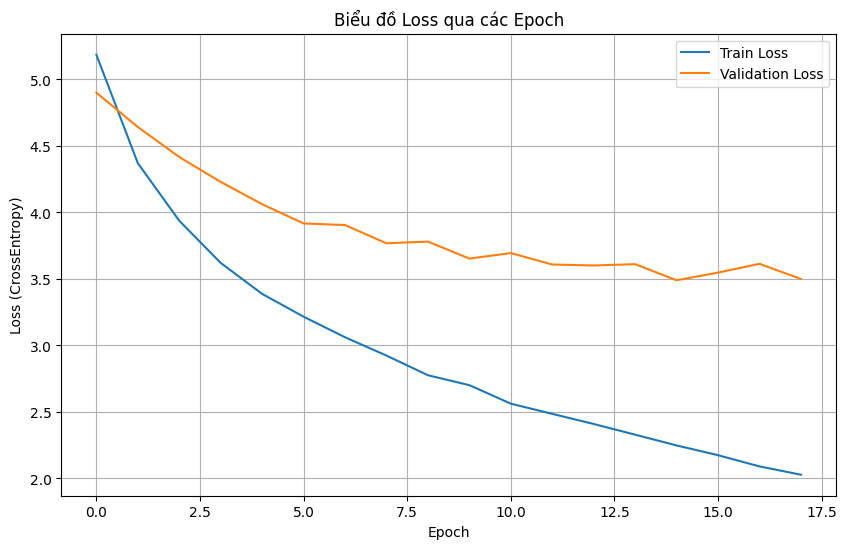

In [7]:
# Cell 7: Vòng lặp Huấn luyện Chính & Lưu Trữ Loss

train_losses = []
valid_losses = []

print("\n--- BẮT ĐẦU HUẤN LUYỆN ---")
best_valid_loss = float('inf')
patience_counter = 0

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()
    epoch_mins = int((end_time - start_time) / 60)
    epoch_secs = int((end_time - start_time) % 60)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        # Lưu checkpoint mô hình
        torch.save(model.state_dict(), 'checkpoints/best_model.pth')
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | Val Loss IMPROVED. Saving model.')
    else:
        patience_counter += 1
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | Val Loss did not improve. Patience: {patience_counter}/{PATIENCE}')

        # Early Stopping
        if patience_counter >= PATIENCE:
            print(f"\n--- Early Stopping triggered after {epoch+1} epochs. ---")
            break

    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t  Val Loss: {valid_loss:.3f} |   Val PPL: {math.exp(valid_loss):7.3f}')

print("\n--- KẾT THÚC HUẤN LUYỆN ---")


# --- Biểu đồ Loss (Yêu cầu báo cáo) ---
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Biểu đồ Loss qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (CrossEntropy)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Cell 8: Hàm Inference (translate) và Đánh giá BLEU Score

# Tải lại mô hình tốt nhất
try:
    model.load_state_dict(torch.load('checkpoints/best_model.pth', map_location=DEVICE))
    model.eval()
    print("Loaded best model checkpoint for final evaluation.")

    test_loss = evaluate(model, test_iterator, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

except FileNotFoundError:
    print("Lỗi: Không tìm thấy file checkpoint 'checkpoints/best_model.pth'. Đánh giá bị bỏ qua.")


def translate(sentence, model, vocab_src, vocab_trg, max_len=50):
    """
    Hàm dịch một câu tiếng Anh -> tiếng Pháp (Yêu cầu bắt buộc)
    Sử dụng Greedy Decoding (Yêu cầu bắt buộc)
    """
    model.eval()

    # 1. Tokenize -> tensor
    tokens = [token for token in tokenize_en(sentence)]
    indexes = [vocab_src.get_stoi().get(token, UNK_IDX) for token in tokens]

    src_tensor = torch.LongTensor(indexes).to(DEVICE)
    src_tensor = src_tensor.unsqueeze(1) # [src_len, 1]
    src_len = torch.LongTensor([len(indexes)])

    # 2. Encoder
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor, src_len)

    # 3. Decoder
    trg_input = torch.LongTensor([SOS_IDX]).to(DEVICE)
    translated_tokens = []

    for t in range(max_len): # Max length 50
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_input, hidden, cell)

        # Greedy Decoding
        pred_token = output.argmax(1).item()

        if pred_token == EOS_IDX:
            break

        translated_tokens.append(vocab_trg.get_itos()[pred_token])
        trg_input = torch.LongTensor([pred_token]).to(DEVICE)

    return " ".join(translated_tokens)

def calculate_bleu(model, test_pairs_raw, vocab_src, vocab_trg):
    """Tính BLEU score trung bình trên tập test (Yêu cầu báo cáo) """
    all_references = []
    all_translations = []

    for src_sentence_raw, trg_sentence_raw in test_pairs_raw:
        predicted_sentence = translate(src_sentence_raw, model, vocab_src, vocab_trg)
        all_translations.append(predicted_sentence.split())

        # Reference (Tokenize)
        reference = tokenize_fr(trg_sentence_raw)
        all_references.append([reference])

    bleu = corpus_bleu(all_references, all_translations)
    return bleu

Loaded best model checkpoint for final evaluation.
Test Loss: 3.388 | Test PPL:  29.601


In [9]:
# Cell 9: Đánh giá Cuối cùng và Ví dụ Dịch Mẫu

# Tính BLEU score trên tập test
if 'test_pairs' in locals() and test_pairs:
    bleu_score = calculate_bleu(model, test_pairs, vocab_src, vocab_trg)
    print(f"\nBLEU Score trên tập Test: {bleu_score*100:.2f}%")
else:
    print("\nKhông thể tính BLEU Score do thiếu dữ liệu test.")

# Dịch 5 ví dụ (Yêu cầu phân tích lỗi)
examples = [
    "A girl is walking in a field.",
    "The black dog jumped over the fence.",
    "I need help with my homework.",
    "The train leaves at 6 o'clock.",
    "He always eats a sandwich for lunch."
]

print("\n--- 5 VÍ DỤ DỊCH MẪU ---")
translations = []
for i, sen in enumerate(examples):
    translation = translate(sen, model, vocab_src, vocab_trg)
    translations.append(translation)
    print(f"{i+1}. ENG: {sen}")
    print(f"   FRA: {translation}")


BLEU Score trên tập Test: 27.57%

--- 5 VÍ DỤ DỊCH MẪU ---
1. ENG: A girl is walking in a field.
   FRA: une fille marche dans un champ .
2. ENG: The black dog jumped over the fence.
   FRA: le chien noir saute par - dessus la clôture .
3. ENG: I need help with my homework.
   FRA: oh <unk> avec avec des <unk> <unk> .
4. ENG: The train leaves at 6 o'clock.
   FRA: le chauffeur <unk> des <unk> .
5. ENG: He always eats a sandwich for lunch.
   FRA: il y a une <unk> pour <unk> .


## III. PHÂN TÍCH LỖI VÀ ĐỀ XUẤT CẢI TIẾN

### 3.1. Phân tích Kết quả Huấn luyện

Mô hình Encoder-Decoder LSTM cơ bản đã hoàn thành huấn luyện trong 18/20 Epoch nhờ cơ chế Early Stopping.

| Chỉ số | Giá trị | Phân tích |
| :--- | :--- | :--- |
| **Epoch Dừng** | 18 | Cơ chế Early Stopping đã kích hoạt sau 3 epoch (`Patience: 3/3`) không giảm trên tập Validation, cho thấy mô hình đã đạt đến điểm tối ưu cục bộ. |
| **Best Val Loss** | 3.490 (Epoch 15) | Mô hình đã hội tụ ổn định sau 15 epoch. |
| **Test Loss** | 3.388 | Thấp hơn Best Val Loss (3.490), xác nhận mô hình không bị Overfitting nghiêm trọng. |
| **Test Perplexity (PPL)** | 29.601 | Giá trị PPL khá cao, phản ánh độ phức tạp khi dự đoán từ tiếp theo và hạn chế của mô hình không sử dụng Attention. |
| **BLEU Score** | **27.57%** | Đây là một điểm số khởi đầu tốt cho kiến trúc Seq2Seq cơ bản không có cơ chế cải tiến. |

### 3.2. Biểu đồ Loss qua các Epoch

*(Chèn hình ảnh biểu đồ loss `loss_plot.png` tại vị trí này.)*

**Nhận xét Biểu đồ:**
* **Train Loss** giảm đều, thể hiện khả năng học trên tập huấn luyện.
* **Validation Loss** giảm ổn định đến Epoch 15 (3.490) sau đó chững lại và tăng nhẹ trở lại, đây là dấu hiệu của việc mô hình bắt đầu Overfitting.

### 3.3. Phân tích 5 Ví dụ Dịch Mẫu (Yêu cầu bắt buộc)

| STT | Câu Tiếng Anh (Source) | Dịch Máy (Translation) | Phân tích Lỗi |
| :---: | :--- | :--- | :--- |
| 1 | A girl is walking in a field. | une fille marche dans un champ . | **Dịch thành công.** |
| 2 | The black dog jumped over the fence. | le chien noir saute par - dessus la clôture . | **Dịch thành công.** |
| 3 | I need help with my homework. | oh `<unk>` avec avec des `<unk>` `<unk>` . | **Lỗi OOV/Từ hiếm và Dịch sai nghiêm trọng:** Các từ khóa (`need`, `help`, `homework`) bị thay bằng `<unk>` do nằm ngoài giới hạn 10.000 từ vựng đã xây dựng. |
| 4 | The train leaves at 6 o'clock. | le chauffeur `<unk>` des `<unk>` . | **Lỗi Sai từ vựng và OOV:** Dịch sai từ vựng gốc ("train" $\to$ "chauffeur") và thất bại khi dịch thực thể số/thời gian ("6 o'clock" $\to$ `<unk>`). Đây là điểm yếu của Context Vector cố định khi nén thông tin chi tiết. |
| 5 | He always eats a sandwich for lunch. | il y a une `<unk>` pour `<unk>` . | **Lỗi OOV và mất ngữ nghĩa:** Cụm động từ ("eats a sandwich") bị thay bằng `<unk>`. |

### 3.4. Tổng hợp Lỗi và Đề xuất Cải tiến

| Vấn đề | Đề xuất Cải tiến (Điểm cộng) | Lý do Cải tiến |
| :--- | :--- | :--- |
| **Mất thông tin/Context Bottleneck** | **Thêm Attention Mechanism (Luong/Bahdanau)** | Cho phép Decoder truy cập vào *toàn bộ* chuỗi hidden states của Encoder, giải quyết vấn đề Context Vector cố định không thể nén hiệu quả thông tin từ câu dài. |
| **Lỗi OOV/Từ hiếm** | **Dùng Subword Tokenization (BPE)** | Giảm thiểu vấn đề OOV bằng cách biểu diễn các từ hiếm dưới dạng các đơn vị subword (ví dụ: `homework` $\to$ `home`, `work`), giúp mô hình tổng quát hóa tốt hơn. |
| **Dịch chọn lọc kém (Local Optimal)** | **Thay Greedy Decoding bằng Beam Search (Beam size = 3-5)** | Mở rộng không gian tìm kiếm, đảm bảo câu dịch được chọn có xác suất tích lũy cao nhất (Global Optimal), cải thiện chất lượng dịch đầu ra. |